# Introduction

This notebook is designed to train an **LSTM** model to classify the rating of a book review. The goal is to develop a model that can accurately predict the rating [0-5] of a given piece of text.

Long Short-Term Memory (LSTM) models are a type of recurrent neural network (RNN) that are well-suited for text classification tasks. LSTMs are able to capture long-term dependencies in the input data, making them particularly effective at classifying sequences of words.

We will be using the **Goodreads Books Review Rating Prediction** dataset from the Kaggle competition of the same name for training and evaluating the model. The dataset consists of 9000 texts, each with a corresponding rating label. The texts are book reviews from the Goodreads website, and the ratings are on a scale from 1 to 5.



## Download kaggle dataset

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp ./kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c goodreads-books-reviews-290312

100% 633M/635M [00:38<00:00, 16.9MB/s]
100% 635M/635M [00:38<00:00, 17.2MB/s]


In [ ]:
! unzip goodreads-books-reviews-290312.zip

Archive:  goodreads-books-reviews-290312.zip
  inflating: goodreads_sample_submission.csv  
  inflating: goodreads_test.csv      
  inflating: goodreads_train.csv     


## Setup

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import re

## Import data

In [ ]:
train_df = pd.read_csv('goodreads_train.csv')
headers = train_df.columns

In [ ]:
train_df

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1
...,...,...,...,...,...,...,...,...,...,...,...
899995,b9450d1c1f97f891c392b1105959b56e,11832081,7c34c15ad8cb28a4afca32946e2016ea,3,3.5 stars. \n Jenna is a popular YA author and...,Fri Nov 16 22:10:17 -0800 2012,Sat Nov 17 22:42:44 -0800 2012,Sat Nov 17 00:00:00 -0800 2012,Fri Nov 16 00:00:00 -0800 2012,0,0
899996,b9450d1c1f97f891c392b1105959b56e,16095092,e979c735276431915d089cfaf446d64f,3,This was a quick read for me. I have read a lo...,Fri Nov 16 22:09:49 -0800 2012,Sat Nov 17 23:38:58 -0800 2012,Sat Nov 17 00:00:00 -0800 2012,Fri Nov 16 00:00:00 -0800 2012,1,1
899997,b9450d1c1f97f891c392b1105959b56e,8430896,feb9fe6439f9fbba8a1cce36020ad977,4,** spoiler alert ** \n 3.5 stars. \n This book...,Tue Nov 13 05:38:24 -0800 2012,Tue Nov 13 23:29:17 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,1,0
899998,b9450d1c1f97f891c392b1105959b56e,12275680,741e29369f70531bfffbd02add86f228,4,** spoiler alert ** \n Another fun read from M...,Mon Nov 12 05:42:30 -0800 2012,Tue Nov 13 22:32:05 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Mon Nov 12 00:00:00 -0800 2012,0,0


### Data info

In [ ]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       900000 non-null  object
 1   book_id       900000 non-null  int64 
 2   review_id     900000 non-null  object
 3   rating        900000 non-null  int64 
 4   review_text   900000 non-null  object
 5   date_added    900000 non-null  object
 6   date_updated  900000 non-null  object
 7   read_at       808234 non-null  object
 8   started_at    625703 non-null  object
 9   n_votes       900000 non-null  int64 
 10  n_comments    900000 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 75.5+ MB


In [ ]:
train_df.shape

(900000, 11)

In [ ]:
train_df.describe()


,book_id,rating,n_votes,n_comments
count,9.000000e+05,900000.000000,900000.000000,900000.000000
mean,1.344145e+07,3.689639,3.294381,1.016656
std,9.357863e+06,1.252583,17.873553,5.963821
min,1.000000e+00,0.000000,-3.000000,-1.000000
25%,6.340471e+06,3.000000,0.000000,0.000000
50%,1.344203e+07,4.000000,0.000000,0.000000
75%,2.057897e+07,5.000000,2.000000,0.000000
max,3.632868e+07,5.000000,3222.000000,1335.000000


In [ ]:
#null values
train_df.isnull().sum()

user_id              0
book_id              0
review_id            0
rating               0
review_text          0
date_added           0
date_updated         0
read_at          91766
started_at      274297
n_votes              0
n_comments           0
dtype: int64

In [ ]:
#duplicated values
train_df.duplicated().sum()

0

In [ ]:
#unique values
train_df.nunique()

user_id          12188
book_id          25474
review_id       900000
rating               6
review_text     890254
date_added      895846
date_updated    883643
read_at         304509
started_at       38280
n_votes            540
n_comments         236
dtype: int64

### Word Cloud

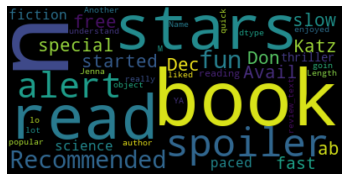

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Select the column containing the words you want to plot
text = str(train_df.review_text)
# Create a word cloud object
wordcloud = WordCloud().generate(text)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Data preprocessing

Drop non purposeful data

In [ ]:
train_df_pre = train_df.drop(['user_id','review_id','date_added','date_updated','read_at','started_at','n_votes','n_comments','book_id'], axis=1)

In [ ]:
train_df_pre

,rating,review_text
0,5,This is a special book. It started slow for ab...
1,3,Recommended by Don Katz. Avail for free in Dec...
2,3,"A fun, fast paced science fiction thriller. I ..."
3,0,Recommended reading to understand what is goin...
4,4,"I really enjoyed this book, and there is a lot..."
...,...,...
899995,3,3.5 stars. \n Jenna is a popular YA author and...
899996,3,This was a quick read for me. I have read a lo...
899997,4,** spoiler alert ** \n 3.5 stars. \n This book...
899998,4,** spoiler alert ** \n Another fun read from M...


### Heatmap

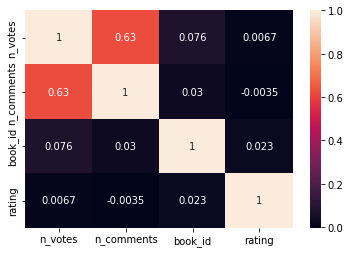

In [ ]:
sns.heatmap(train_df[['n_votes','n_comments','book_id','rating']].corr(), annot=True)

In [ ]:
train_df.rating.value_counts()


4    313688
5    265007
3    188972
2     72627
0     30988
1     28718
Name: rating, dtype: int64

### Ratings count

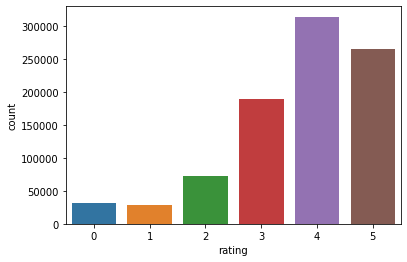

In [ ]:
sns.countplot(x=train_df.rating)

## Preprocessing functions

In [ ]:
import re
import string

In [ ]:
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.extend(['book', 'books', 'series', 'star', 'stars', 'story', 'characters', 'character', 'read','review','spoiler','alert'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def noise_removing(df):
    # Lower case the review text
    df['review_text'] = df['review_text'].str.lower()
    
    # Remove punctuation
    df['review_text'] = df['review_text'].str.translate(str.maketrans('', '', string.punctuation))
    
    # Remove digits
    df['review_text'] = df['review_text'].str.replace(r'\d', '', regex=True)
    
    # Remove links and URLs
    df['review_text'] = df['review_text'].str.replace(r'http\S+|www\S+', '', regex=True)
    
    # Remove special sequences and spoilers
    df['review_text'] = df['review_text'].replace(r"spoiler alert", '', regex=True)
    df['review_text'] = df['review_text'].replace(r'(\(view spoiler\).*?\(hide spoiler\))', '', regex=True)
    df['review_text'] = df['review_text'].replace('\n' , "",regex=True)
    
    # Remove quotes
    df['review_text'] = df['review_text'].replace(r'"([^"\\]|\\.)*"', '', regex=True)
    
    # Remove non-alphabetic characters
    df['review_text'] = df['review_text'].str.replace(r'[^\w\s]', '', regex=True)
    
    # Remove extra whitespace
    df['review_text'] = df['review_text'].str.replace(' +', ' ')
    df['review_text'] = df['review_text'].str.replace('\s*,\s*', ',')


### Removing noises from data

In [ ]:
noise_removing(train_df_pre)


<ipython-input-15-45bcceefc841>:26: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_text'] = df['review_text'].str.replace(' +', ' ')
<ipython-input-15-45bcceefc841>:27: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_text'] = df['review_text'].str.replace('\s*,\s*', ',')


In [ ]:
train_df_pre

,rating,review_text
0,5,this is a special book it started slow for abo...
1,3,recommended by don katz avail for free in dece...
2,3,a fun fast paced science fiction thriller i re...
3,0,recommended reading to understand what is goin...
4,4,i really enjoyed this book and there is a lot ...
...,...,...
899995,3,stars jenna is a popular ya author and her ag...
899996,3,this was a quick read for me i have read a lot...
899997,4,stars this book is sweet inside and out whats...
899998,4,another fun read from ms evanovich diesel and...


### Removing stop words

In [ ]:
#removing stop words
stop = set(stopwords.words('english'))
# train_df_pre.review_text = train_df_pre.review_text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_df_pre['review_text'] = train_df_pre['review_text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop))

In [ ]:
train_df_pre


(        rating                                        review_text
 0            5  special book started slow first third middle t...
 1            3               recommended katz avail free december
 2            3  fun fast paced science fiction thriller read n...
 3            0  recommended reading understand going middle am...
 4            4  really enjoyed book lot recommend drag little ...
 ...        ...                                                ...
 899995       3  stars jenna popular ya author agent wants char...
 899996       3  quick read read lot new adult books recently o...
 899997       4  stars book sweet inside whats sweeter ice crea...
 899998       4  another fun read ms evanovich diesel lizzys ne...
 899999       3  stars liked story original well written find j...
 
 [900000 rows x 2 columns],
                                               review_text
 0       definitely one favorites among food books ive ...
 1       drink im huge fan coffee dont buy coffe

### Slicing data into input and output

In [ ]:
X = train_df_pre.review_text
from tensorflow.keras.utils import to_categorical

y = to_categorical(train_df['rating'])
y.shape



(900000, 6)

In [ ]:
X

0         special book started slow first third middle t...
1                      recommended katz avail free december
2         fun fast paced science fiction thriller read n...
3         recommended reading understand going middle am...
4         really enjoyed book lot recommend drag little ...
                                ...                        
899995    stars jenna popular ya author agent wants char...
899996    quick read read lot new adult books recently o...
899997    stars book sweet inside whats sweeter ice crea...
899998    another fun read ms evanovich diesel lizzys ne...
899999    stars liked story original well written find j...
Name: review_text, Length: 900000, dtype: object

### Tokenizing

In [ ]:
from keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index
print('Vocabulary size found:', len(word_index))


Vocabulary size found: 638123


In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)


In [ ]:
print('Shape of data tensor:', X.shape)

Shape of data tensor: (900000, 250)


## Split train set into train and test sets


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=42)


## Import embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-01-09 09:16:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-09 09:16:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-09 09:16:26--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

## Embedding

In [ ]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
# BATCH_SIZE = 8
# EPOCHS = 10


In [ ]:
embeddings_index = {}

f = open(GLOVE_EMB, encoding='utf-8')

for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
import tensorflow as tf

In [ ]:
#embedding layer
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# Model Training - LSTM

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from keras.layers import Embedding, LSTM, SpatialDropout1D, Bidirectional, Dropout, Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = Sequential()
# Add the embedding layer
model.add(embedding_layer)

# Add SpatialDropout1D
model.add(SpatialDropout1D(0.2))
# Add the bidirectional LSTM layer
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
# Add the dropout layer
model.add(Dropout(0.5))
# Add the dense layer
model.add(Dense(128, activation='relu'))

# Add the output layer
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)




In [ ]:
BATCH_SIZE = 1152
EPOCHS = 10
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
625/625 [==============================] - 597s 944ms/step - loss: 1.2780 - accuracy: 0.4512 - val_loss: 1.1552 - val_accuracy: 0.5047 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - 577s 923ms/step - loss: 1.1706 - accuracy: 0.4969 - val_loss: 1.1108 - val_accuracy: 0.5232 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - 576s 922ms/step - loss: 1.1429 - accuracy: 0.5089 - val_loss: 1.1107 - val_accuracy: 0.5240 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - 574s 919ms/step - loss: 1.1275 - accuracy: 0.5148 - val_loss: 1.0803 - val_accuracy: 0.5357 - lr: 0.0010
Epoch 5/10
625/625 [==============================] - 568s 909ms/step - loss: 1.1166 - accuracy: 0.5200 - val_loss: 1.0760 - val_accuracy: 0.5403 - lr: 0.0010
Epoch 6/10
625/625 [==============================] - 581s 930ms/step - loss: 1.1088 - accuracy: 0.5234 - val_loss: 1.0682 - val_accuracy: 0.5428 - lr: 0.0010
Epoch 7/10
625/625 [==========================

### Model metrics visualisation

Text(0, 0.5, 'Accuracy [%]')

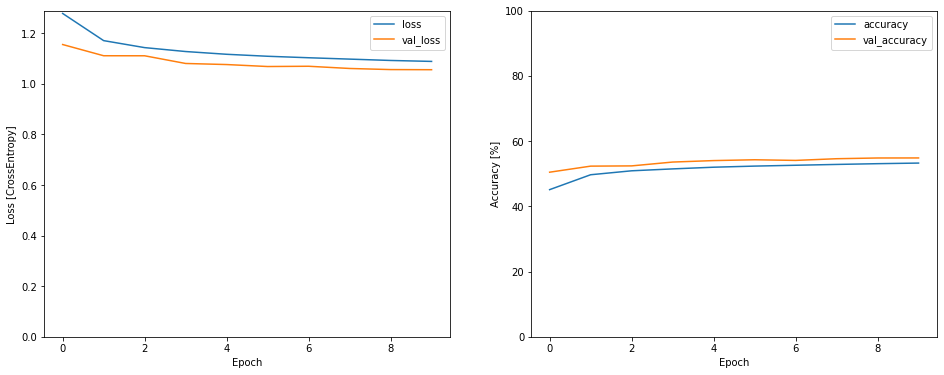

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_test, y_test)


In [ ]:
model.save("saved_model")

In [ ]:
!zip -r ./saved_model.zip ./saved_model

  adding: saved_model/ (stored 0%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/saved_model.pb (deflated 91%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 66%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 83%)
  adding: saved_model/keras_metadata.pb (deflated 90%)


In [ ]:
test_df = pd.read_csv('goodreads_test.csv')
#remove noises in textx
noise_removing(test_df)
#remove stop words
test_df['review_text'] = test_df['review_text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop))
test = test_df['review_text']
test = tokenizer.texts_to_sequences(test.values)
test = pad_sequences(test, maxlen=MAX_SEQUENCE_LENGTH)

<ipython-input-46-b6ef2677291e>:26: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_text'] = df['review_text'].str.replace(' +', ' ')
<ipython-input-46-b6ef2677291e>:27: FutureWarning: The default value of regex will change from True to False in a future version.
  df['review_text'] = df['review_text'].str.replace('\s*,\s*', ',')


In [ ]:
test = tokenizer.texts_to_sequences(test.values)
test = pad_sequences(test, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
sub = pd.DataFrame()
sub['review_id'] = test_df.review_id
sub['rating'] = [np.argmax(i) for i in model.predict(test)]
sub.head()

14939/14939 [==============================] - 1937s 130ms/step


,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,5
1,8eaeaf13213eeb16ad879a2a2591bbe5,3
2,dce649b733c153ba5363a0413cac988f,5
3,8a46df0bb997269d6834f9437a4b0a77,3
4,d11d3091e22f1cf3cb865598de197599,4


In [ ]:
loaded_model = tf.keras.models.load_model(r'app\model\saved_model')

In [ ]:
rat = model.predict('lovely love ')

NameError: ignored

In [ ]:
sub.to_csv("submission.csv", index = False)